# Exploratory Data Analysis for LLM-Redial Dataset

In [27]:
import sys
import os
sys.path.append(os.path.abspath(".."))

import config
import tiktoken
import nltk
import polars as pl
import matplotlib.pyplot as plt

from scripts.data_loader import DataLoader
from scripts.utils import compute_category_stats, split_dialogue_by_newline
from scripts.Tools import read_dialogue

## Packages
We import the tokenizer, common stopwords, lemmatization (wordnet) and part-of-speech tagging.

In [2]:
nltk.download("punkt")
nltk.download("punkt_tab")
nltk.download("stopwords")
nltk.download("wordnet")
nltk.download("averaged_perceptron_tagger")

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/nicolasespinoza/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     /Users/nicolasespinoza/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/nicolasespinoza/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/nicolasespinoza/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/nicolasespinoza/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

## Data loading
We used the DataLoader class to load the data. Returns a dict for each type of dataset tat we have on data.

In [3]:
loader = DataLoader()
dataframes = loader.load_data()

Loading data for Movies...
Data for Movies loaded successfully.

Loading data for Books...
Data for Books loaded successfully.

Loading data for Electronics...
Data for Electronics loaded successfully.

Loading data for Sports...
Data for Sports loaded successfully.



In [4]:
dataframes.keys()

dict_keys(['Movies', 'Books', 'Electronics', 'Sports'])

To access the loaded dataframes, we need to access to the category of the data and then check the different dataframes.

In [5]:
dataframes["Movies"].keys()

dict_keys(['item_map', 'user_map', 'final_data', 'dialogues'])

Finally, we can access to a dataframe.

In [6]:
dataframes["Movies"]["final_data"].sample(2)

user_id,history_interaction,user_might_like,conversations
str,list[str],list[str],struct[15]
"""A2I92HD4VS0SJW""","[""B00004RFHO"", ""630442972X"", … ""6304673043""]","[""6302136229""]","{{8057,[""6304673043""],[],[""6302136229""]},null,null,null,null,null,null,null,null,null,null,null,null,null,null}"
"""A3R4ZEDVRUWJNO""","[""B000BITUWU"", ""1563311976"", … ""B00064LJVO""]","[""B00005JLSE""]","{{5642,[""1563311976"", ""B000BX8R10""],[""B00064LJVO""],[""B00005JLSE""]},null,null,null,null,null,null,null,null,null,null,null,null,null,null}"


And we check that the "conversation" field of the dataframe is a dictionary containing all the necessary information.

In [7]:
dataframes["Movies"]["final_data"].item(1, "user_id")

'A2NBOL825B93OM'

In [8]:
dataframes["Movies"]["final_data"].item(1, "conversations")

{'conversation_1': {'conversation_id': 2,
  'user_likes': ['B00003CWT6'],
  'user_dislikes': ['B00003CXTL'],
  'rec_item': ['B00Z9YZRVE']},
 'conversation_2': {'conversation_id': 3,
  'user_likes': ['B0009WK5CW', 'B00008W64E'],
  'user_dislikes': ['6303575617'],
  'rec_item': ['B0001K2L4W']},
 'conversation_3': {'conversation_id': 4,
  'user_likes': ['B00005JKN2'],
  'user_dislikes': ['B00003CXTL', '6303575617', 'B00008MTXY'],
  'rec_item': ['B00005JN2Z']},
 'conversation_4': None,
 'conversation_5': None,
 'conversation_6': None,
 'conversation_7': None,
 'conversation_8': None,
 'conversation_9': None,
 'conversation_10': None,
 'conversation_11': None,
 'conversation_12': None,
 'conversation_13': None,
 'conversation_14': None,
 'conversation_15': None}

## Processing

In [46]:
for category, dfs in dataframes.items():
    dfs["dialogues"] = split_dialogue_by_newline(dfs["dialogues"])
    print(f"Processed dialogues for {category}:")
    print(dfs["dialogues"].head())

Processed dialogues for Movies:
shape: (5, 2)
┌─────────────────┬─────────────────────────────────┐
│ conversation_id ┆ dialogue                        │
│ ---             ┆ ---                             │
│ i64             ┆ list[str]                       │
╞═════════════════╪═════════════════════════════════╡
│ 0               ┆ ["User: Hi, I'm Mark Savary. I… │
│ 1               ┆ ["User: Hi there! I recently w… │
│ 2               ┆ ["User: Hello, I had a terribl… │
│ 3               ┆ ["User: Hi! I recently watched… │
│ 4               ┆ ["User: Hi there! I've had a t… │
└─────────────────┴─────────────────────────────────┘
Processed dialogues for Books:
shape: (5, 2)
┌─────────────────┬─────────────────────────────────┐
│ conversation_id ┆ dialogue                        │
│ ---             ┆ ---                             │
│ i64             ┆ list[str]                       │
╞═════════════════╪═════════════════════════════════╡
│ 0               ┆ ["User: Hello! I recently

## EDA

1. Compute statistics for each dataframe.

In [52]:
enc = tiktoken.get_encoding("gpt2")

def compute_category_stats(category: str, dfs: Dict[str, pl.DataFrame]) -> Dict[str, Any]:
    """
    Computes statistics for a given category in the LLM-Redial dataset.

    Args:
        category (str): The name of the category (e.g., "Books", "Movies").
        dfs (Dict[str, pl.DataFrame]): A dictionary of Polars DataFrames for the category,
                                       containing 'final_data', 'dialogues', and 'item_map' DataFrames.

    Returns:
        Dict[str, Any]: A dictionary containing various statistics for the category including
                        number of dialogues, utterances, tokens, 4-grams, users, items, and averages.
    """
    df_dialogues = dfs["dialogues"]
    df_item_map = dfs["item_map"]
    df_user_map = dfs["user_map"]

    num_dialogues = df_dialogues.n_unique(subset="conversation_id")

    num_users = df_user_map.n_unique(subset="user_info")
    num_items = df_item_map.n_unique(subset="item_name")

    num_utterances = df_dialogues.with_columns(
        pl.struct(["dialogue"])
          .map_elements(lambda row: len(row["dialogue"]), return_dtype=pl.Int64)
          .alias("num_dialogues")
    )["num_dialogues"].sum()

    total_tokens = df_dialogues.with_columns(
        pl.struct(["dialogue"])
          .map_elements(
              lambda row: sum(len(enc.encode(segment)) for segment in row["dialogue"]),
              return_dtype=pl.Int64
          ).alias("total_tokens")
    )["total_tokens"].sum()

    total_4grams = df_dialogues.with_columns(
        pl.struct(["dialogue"])
          .map_elements(
              lambda row: sum(max(len(enc.encode(segment)) - 3, 0) for segment in row["dialogue"]),
              return_dtype=pl.Int64
          ).alias("total_4grams")
    )["total_4grams"].sum()

    avg_dialogues_per_user = num_dialogues / num_users if num_users > 0 else 0
    avg_utterances_per_dialogue = num_utterances / num_dialogues if num_dialogues > 0 else 0

    return {
        "Category": category,
        "#Dialogues": num_dialogues,
        "#Utterances": num_utterances,
        "#Tokens": total_tokens,
        "#4-Grams": total_4grams,
        "#Users": num_users,
        "#Items": num_items,
        "Avg. #Dialogues per User": round(avg_dialogues_per_user, 2),
        "Avg. #Utterances per Dialogue": round(avg_utterances_per_dialogue, 2)
    }

In [53]:
category_stats_list = []
for category, dfs in dataframes.items():
    category_stats = compute_category_stats(category, dfs)
    category_stats_list.append(category_stats)

stats_df = pl.DataFrame(category_stats_list)

In [55]:
stats_df = stats_df.with_columns(
    [
        pl.col("*").exclude("Category").cast(pl.Float64)
    ]
)

In [56]:
pl.concat(
   [
      stats_df.select(
         pl.col(["Category", "#Dialogues", "#Utterances", "#Tokens", "#4-Grams", "#Users", "#Items"])
      ).melt(
         "Category", variable_name="Stat"
      ).pivot(
         on="Category", index="Stat", values="value"
      ).select(
         ["Stat", "Books", "Movies", "Sports", "Electronics"]
      ).with_columns(
         pl.fold(0, lambda acc, s: acc + s, pl.exclude("Stat")).cast(pl.Float64).alias("Total")
      ),
      stats_df.select(
         pl.col(["Category", "Avg. #Dialogues per User", "Avg. #Utterances per Dialogue"])
      ).melt(
         "Category", variable_name="Stat"
      ).pivot(
         on="Category", index="Stat", values="value"
      ).select(
         ["Stat", "Books", "Movies", "Sports", "Electronics"]
      ).with_columns(
         pl.fold(0, lambda acc, s: acc + s, pl.exclude("Stat")).alias("Total") / 4
      )
   ],
   how="vertical"
)


/var/folders/3y/l3lqhvkx0j711gxmcxbp33wr0000gp/T/ipykernel_71725/3823963867.py:5: DeprecationWarning: `DataFrame.melt` is deprecated. Use `unpivot` instead, with `index` instead of `id_vars` and `on` instead of `value_vars`
  ).melt(
/var/folders/3y/l3lqhvkx0j711gxmcxbp33wr0000gp/T/ipykernel_71725/3823963867.py:16: DeprecationWarning: `DataFrame.melt` is deprecated. Use `unpivot` instead, with `index` instead of `id_vars` and `on` instead of `value_vars`
  ).melt(


Stat,Books,Movies,Sports,Electronics,Total
str,f64,f64,f64,f64,f64
"""#Dialogues""",25016.0,10089.0,6212.0,6259.0,47576.0
"""#Utterances""",264381.0,106189.0,67837.0,67079.0,505486.0
"""#Tokens""",9.257696e6,3.818186e6,2.491403e6,2.508005e6,1.807529e7
"""#4-Grams""",8.464597e6,3.499638e6,2.287896e6,2.306768e6,1.6558899e7
"""#Users""",9852.0,3131.0,5083.0,4444.0,22510.0
"""#Items""",169152.0,9518.0,37003.0,18957.0,234630.0
"""Avg. #Dialogues per User""",2.54,3.22,1.22,1.41,2.0975
"""Avg. #Utterances per Dialogue""",10.57,10.53,10.92,10.72,10.685


Note that there is a difference between this results and the paper's results.

2. User-Item distribution

In [60]:
for category, dfs in dataframes.items():
    user_item_interactions = (
        dfs["final_data"].explode("history_interaction")
        .select(["user_id", "history_interaction"])
    )

    user_item_interactions = user_item_interactions.with_columns(
        pl.lit(1).alias("interaction")
    )

    user_item_matrix = (
        user_item_interactions
        .pivot(
            index="user_id",
            columns="history_interaction",
            values="interaction",
            aggregate_function="first"  # Choose the first occurrence (since it's binary, all values will be 1)
        )
        .fill_null(0)
    )
    
    print(f"User-item matrix dimensions for {category}: {user_item_matrix.shape}")

user_item_matrix

/var/folders/3y/l3lqhvkx0j711gxmcxbp33wr0000gp/T/ipykernel_71725/1169295049.py:16: DeprecationWarning: The argument `columns` for `DataFrame.pivot` is deprecated. It has been renamed to `on`.
  .pivot(


User-item matrix dimensions for Movies: (3131, 9686)
User-item matrix dimensions for Books: (9852, 172540)
User-item matrix dimensions for Electronics: (4444, 18074)
User-item matrix dimensions for Sports: (5083, 35449)


user_id,B000IUWLNG,B0053C3WDC,B005ADGW1I,B00BJLBE68,B00HFAJZK4,B000UVVX28,B000BTNLVK,B014ODAX9G,B00TP8KCOC,B002IJ7LV2,B00GJNQLHS,B015HQ6CTO,B00RWFOKYI,B006QWLDZM,B0009R96YK,B002UNMETK,B004SOG6H0,B0179SD8YK,B00ISN3YLI,B000YYYP3K,B007GCHMKG,B0048LP6GA,B0147HRECI,B000C128PM,B00LFUBQG6,B001AIVF4G,B0020HDLGQ,B0019MM47U,B00N5PLOJS,B001RQRXJW,B00171UHEK,B004A9N27A,B00DUZ23SE,B000MEEDT8,B004S76WTE,B002331U0G,…,B003TIY39Y,B00BI3HSD0,B001CNRVPQ,B000KJA6Y6,B00KGNTT7G,B00OU6RQNO,B00MFZ8F5K,B00YBWC1T6,B002B8YQ9U,B00HURW3LA,B00HY921DY,B00LD3NDB6,B0030RSAHK,B000HS1680,B00SZ2MVC0,B00J0RZY00,B006G0NMXA,B015EQ2ZIO,B00K2S1MK2,B005JRNZWE,B013GLVNUK,B00P4HHZ0C,B00O60IPFC,B00MTVNJ9M,B01FKWRKN2,B011US7EYK,B004J2GUP4,B000F8JMLU,B004C2XOFK,B00R15A1QU,B016MY69CK,B000IMT1M8,B0091IVMPE,B000O8D8QG,B018S832W8,B000E8HX80,B001PTHKQC
str,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,…,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32
"""A1RH54KDESZ72N""",1,1,1,1,1,1,1,1,1,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,…,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
"""A1RI10H2OWV8ZJ""",0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0,0,0,0,0,0,0,…,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
"""A1RI4729EOP9EP""",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,…,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
"""A1RJ4BW5Z1BNUL""",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,…,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
"""A1RJW14OJGSP22""",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,…,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
"""A3FOBECZY4OTU2""",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,…,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
"""A3FOIKY8J4558L""",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,…,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0
"""A3FR4ODI2BKEWF""",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,…,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


- Average Number of Interactions per User

In [63]:
interactions_per_user = user_item_matrix.select(
    pl.sum_horizontal(pl.all().exclude("user_id")).alias("total_interactions")
)
average_interactions_per_user = interactions_per_user["total_interactions"].mean()
print(f"Average interactions per user: {average_interactions_per_user}")


Average interactions per user: 15.084202242770017


- Average Number of Interactions per Item

In [72]:
melted_df = user_item_matrix.melt(
    id_vars="user_id",
    variable_name="item_id",
    value_name="interaction"
)

item_stats = melted_df.drop("user_id").group_by("item_id").agg([
    pl.col("interaction").mean().alias("mean"),
    pl.col("interaction").std().alias("std"),
    pl.col("interaction").min().alias("min"),
    pl.col("interaction").max().alias("max"),
    pl.col("interaction").filter(pl.col("interaction") != 0).count().alias("non_zero_count")
])

item_stats

/var/folders/3y/l3lqhvkx0j711gxmcxbp33wr0000gp/T/ipykernel_71725/4113757318.py:2: DeprecationWarning: `DataFrame.melt` is deprecated. Use `unpivot` instead, with `index` instead of `id_vars` and `on` instead of `value_vars`
  melted_df = user_item_matrix.melt(


item_id,mean,std,min,max,non_zero_count
str,f64,f64,i32,i32,u32
"""B001H53Q6M""",0.004328,0.065653,0,1,22
"""B0085CGOEQ""",0.000197,0.014026,0,1,1
"""B000C12DS4""",0.000787,0.028044,0,1,4
"""B00G9UR7BU""",0.00059,0.024289,0,1,3
"""B000U3DUHC""",0.000393,0.019834,0,1,2
…,…,…,…,…,…
"""B00P03TCQU""",0.000393,0.019834,0,1,2
"""B001LNWC0Q""",0.000197,0.014026,0,1,1
"""B00171MVU8""",0.000197,0.014026,0,1,1


In [73]:
item_stats.select("non_zero_count").describe()


statistic,non_zero_count
str,f64
"""count""",35448.0
"""null_count""",0.0
"""mean""",2.162971
"""std""",2.850946
"""min""",1.0
"""25%""",1.0
"""50%""",1.0
"""75%""",2.0
"""max""",96.0


Tenemos que en promedio los items tiene dos interacciones con los usuarios y un máximo de 96 interacciones.

3. Number of Conversations per User

In [82]:
dataframes['Books']['final_data']['conversations'].item(0)

{'conversation_1': {'conversation_id': 0,
  'user_likes': ['1523858117', '1943686750'],
  'user_dislikes': [],
  'rec_item': ['1492231452']},
 'conversation_2': {'conversation_id': 1,
  'user_likes': ['1530643775', '1466344946', '1517758947'],
  'user_dislikes': [],
  'rec_item': ['1549627813']},
 'conversation_3': None,
 'conversation_4': None,
 'conversation_5': None,
 'conversation_6': None,
 'conversation_7': None,
 'conversation_8': None,
 'conversation_9': None,
 'conversation_10': None,
 'conversation_11': None,
 'conversation_12': None,
 'conversation_13': None,
 'conversation_14': None,
 'conversation_15': None,
 'conversation_16': None,
 'conversation_17': None,
 'conversation_18': None,
 'conversation_19': None,
 'conversation_20': None,
 'conversation_21': None,
 'conversation_22': None,
 'conversation_23': None}

In [84]:
for category, dfs in dataframes.items():
    df_final_data = dfs["final_data"]

    def count_non_none_conversations(convs):
        if isinstance(convs, dict):
            return sum(1 for v in convs.values() if v is not None)
        return 0
    
    df_final_data = df_final_data.with_columns(
        pl.col("conversations").map_elements(count_non_none_conversations).alias("num_conversations")
    )

    conversations_summary = df_final_data.select(pl.col("num_conversations")).describe()
    
    print(f"Conversations summary for {category}:")
    print(conversations_summary)


Conversations summary for Movies:
shape: (9, 2)
┌────────────┬───────────────────┐
│ statistic  ┆ num_conversations │
│ ---        ┆ ---               │
│ str        ┆ f64               │
╞════════════╪═══════════════════╡
│ count      ┆ 3131.0            │
│ null_count ┆ 0.0               │
│ mean       ┆ 2.962312          │
│ std        ┆ 2.927426          │
│ min        ┆ 1.0               │
│ 25%        ┆ 1.0               │
│ 50%        ┆ 2.0               │
│ 75%        ┆ 3.0               │
│ max        ┆ 15.0              │
└────────────┴───────────────────┘
Conversations summary for Books:
shape: (9, 2)
┌────────────┬───────────────────┐
│ statistic  ┆ num_conversations │
│ ---        ┆ ---               │
│ str        ┆ f64               │
╞════════════╪═══════════════════╡
│ count      ┆ 9852.0            │
│ null_count ┆ 0.0               │
│ mean       ┆ 2.338713          │
│ std        ┆ 3.049797          │
│ min        ┆ 1.0               │
│ 25%        ┆ 1.0            

/var/folders/3y/l3lqhvkx0j711gxmcxbp33wr0000gp/T/ipykernel_71725/1032952204.py:11: MapWithoutReturnDtypeWarning: Calling `map_elements` without specifying `return_dtype` can lead to unpredictable results. Specify `return_dtype` to silence this warning.
  df_final_data = df_final_data.with_columns(
/var/folders/3y/l3lqhvkx0j711gxmcxbp33wr0000gp/T/ipykernel_71725/1032952204.py:11: MapWithoutReturnDtypeWarning: Calling `map_elements` without specifying `return_dtype` can lead to unpredictable results. Specify `return_dtype` to silence this warning.
  df_final_data = df_final_data.with_columns(
/var/folders/3y/l3lqhvkx0j711gxmcxbp33wr0000gp/T/ipykernel_71725/1032952204.py:11: MapWithoutReturnDtypeWarning: Calling `map_elements` without specifying `return_dtype` can lead to unpredictable results. Specify `return_dtype` to silence this warning.
  df_final_data = df_final_data.with_columns(
/var/folders/3y/l3lqhvkx0j711gxmcxbp33wr0000gp/T/ipykernel_71725/1032952204.py:11: MapWithoutReturnDtyp

4. Lenght distribution of conversations by category (words and tokens)

In [104]:

enc = tiktoken.get_encoding("gpt2")

def calculate_conversation_length(df: pl.DataFrame) -> pl.DataFrame:
    """
    Calculates the length in words and tokens for each conversation.

    Args:
        df (pl.DataFrame): The DataFrame containing the 'dialogue' column with lists of strings.

    Returns:
        pl.DataFrame: The DataFrame with added columns for word and token lengths.
    """
    def unify_and_calculate_lengths(dialogue):
        if isinstance(dialogue['dialogue'], list):
            unified_dialogue = " ".join(dialogue['dialogue'])  # Join list items into a single string
            word_count = len(unified_dialogue.split())  # Calculate number of words
            token_count = len(enc.encode(unified_dialogue))  # Calculate number of tokens

            return {"word_length": word_count, "token_length": token_count}
        return {"word_length": 0, "token_length": 0}

    return df.with_columns(
        pl.struct("dialogue").map_elements(unify_and_calculate_lengths).alias("lengths")
    ).with_columns([
        pl.col("lengths").struct.field("word_length"),
        pl.col("lengths").struct.field("token_length")
    ]).drop("lengths")


In [105]:
def plot_length_distributions(df: pl.DataFrame, category: str):
    """
    Plots the distribution of conversation lengths in words and tokens.

    Args:
        df (pl.DataFrame): The DataFrame containing word and token lengths.
        category (str): The name of the category (e.g., "Books", "Movies").
    """
    plt.figure(figsize=(14, 6))

    plt.subplot(1, 2, 1)
    plt.hist(df["word_length"].to_numpy(), bins=50, color='blue', alpha=0.7)
    plt.title(f"Word Length Distribution for {category}")
    plt.xlabel("Length in Words")
    plt.ylabel("Frequency")

    plt.subplot(1, 2, 2)
    plt.hist(df["token_length"].to_numpy(), bins=50, color='green', alpha=0.7)
    plt.title(f"Token Length Distribution for {category}")
    plt.xlabel("Length in Tokens")
    plt.ylabel("Frequency")

    plt.tight_layout()
    plt.show()

/var/folders/3y/l3lqhvkx0j711gxmcxbp33wr0000gp/T/ipykernel_71725/3352422701.py:22: MapWithoutReturnDtypeWarning: Calling `map_elements` without specifying `return_dtype` can lead to unpredictable results. Specify `return_dtype` to silence this warning.
  return df.with_columns(


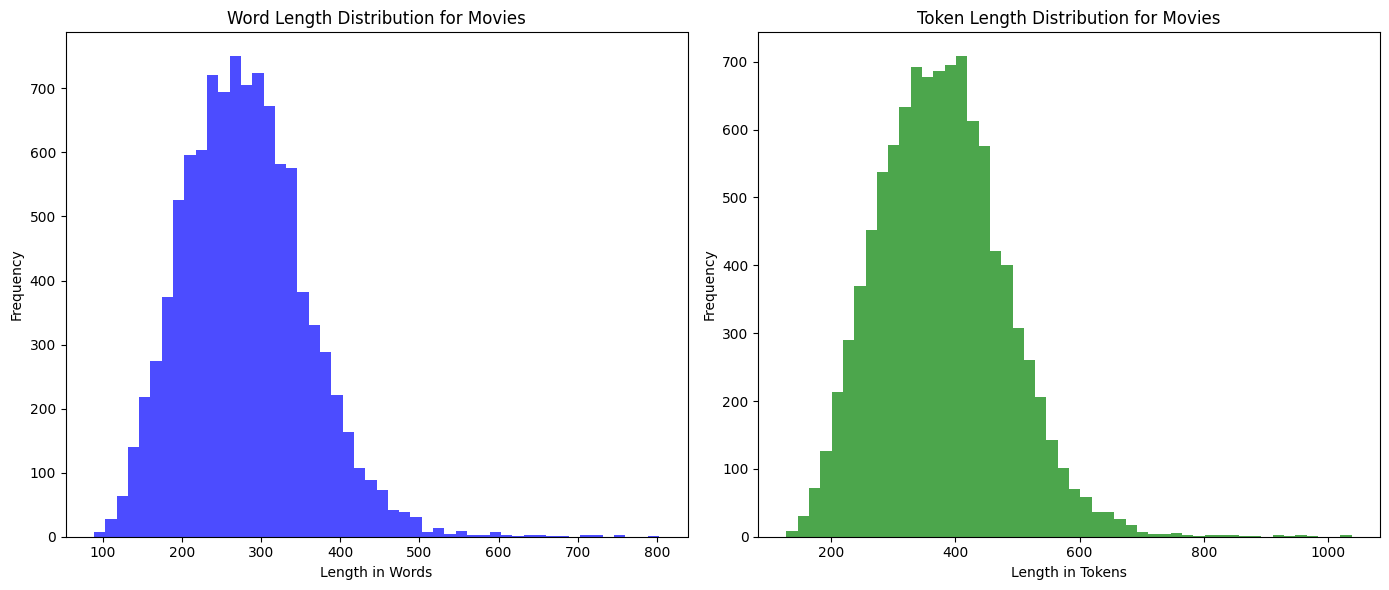

/var/folders/3y/l3lqhvkx0j711gxmcxbp33wr0000gp/T/ipykernel_71725/3352422701.py:22: MapWithoutReturnDtypeWarning: Calling `map_elements` without specifying `return_dtype` can lead to unpredictable results. Specify `return_dtype` to silence this warning.
  return df.with_columns(


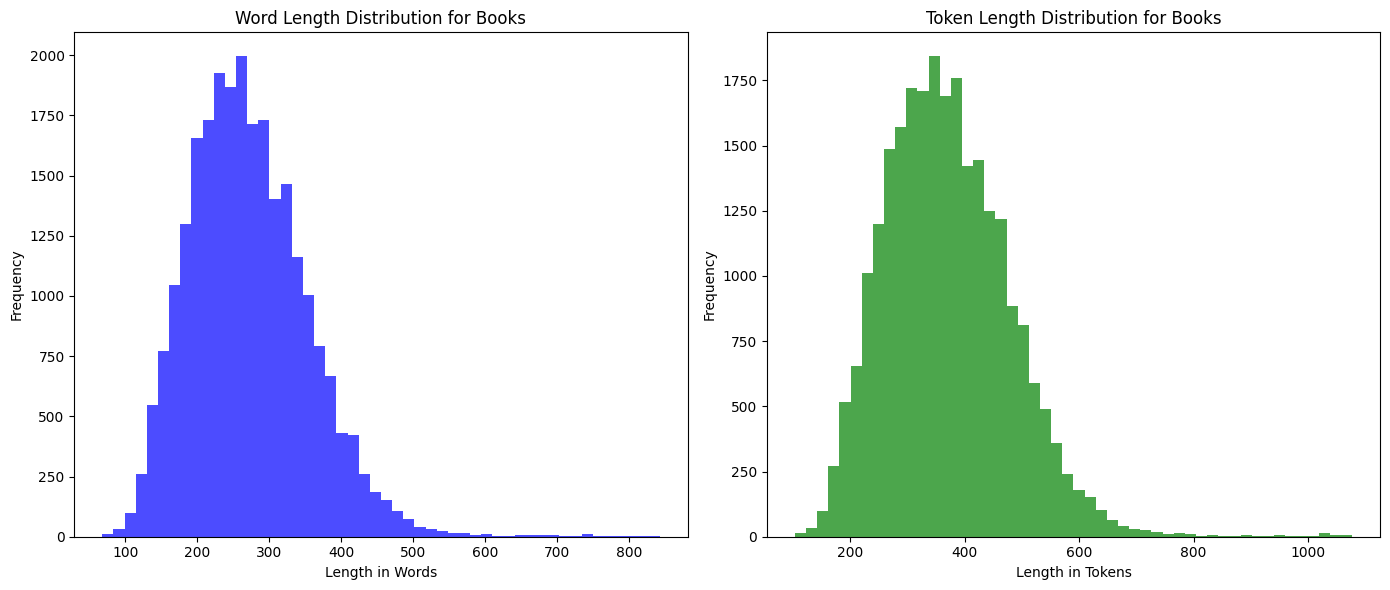

/var/folders/3y/l3lqhvkx0j711gxmcxbp33wr0000gp/T/ipykernel_71725/3352422701.py:22: MapWithoutReturnDtypeWarning: Calling `map_elements` without specifying `return_dtype` can lead to unpredictable results. Specify `return_dtype` to silence this warning.
  return df.with_columns(


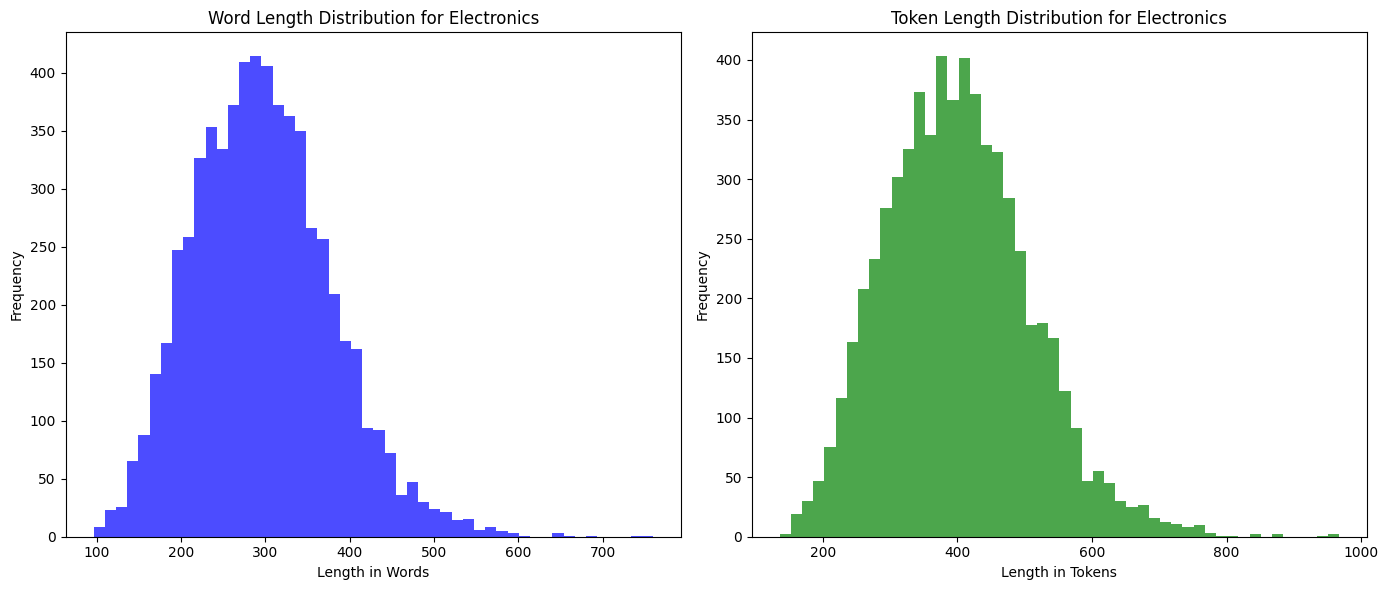

/var/folders/3y/l3lqhvkx0j711gxmcxbp33wr0000gp/T/ipykernel_71725/3352422701.py:22: MapWithoutReturnDtypeWarning: Calling `map_elements` without specifying `return_dtype` can lead to unpredictable results. Specify `return_dtype` to silence this warning.
  return df.with_columns(


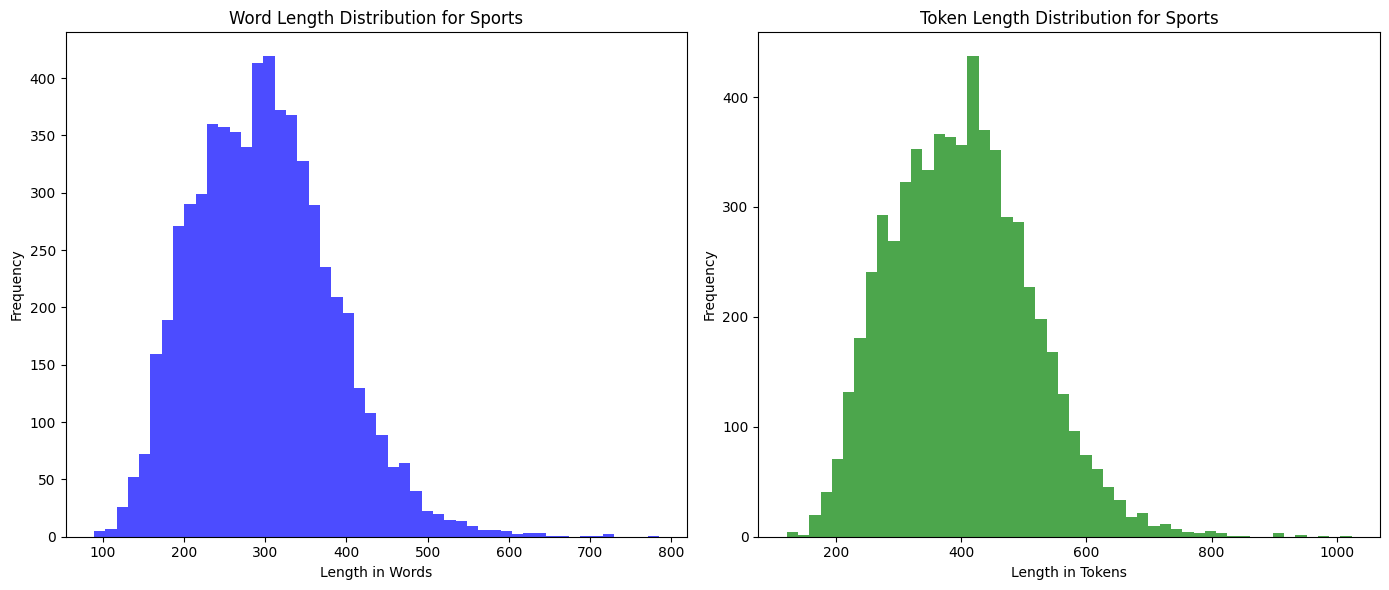

In [106]:
for category, dfs in dataframes.items():
    df_dialogues = calculate_conversation_length(dfs["dialogues"])
    plot_length_distributions(df_dialogues, category)